<a href="https://colab.research.google.com/github/Lionel-Lim/casa0018/blob/main/casa0018/Assessment/Projects/Final%20Project/src/trainingData/trainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
!wget https://github.com/Lionel-Lim/casa0018/raw/main/Assessment/Projects/Final%20Project/src/trainingData/filteredDataSet.zip
!unzip filteredDataSet.zip

--2023-03-13 22:38:50--  https://github.com/Lionel-Lim/casa0018/raw/main/Assessment/Projects/Final%20Project/src/trainingData/filteredDataSet.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Lionel-Lim/casa0018/main/Assessment/Projects/Final%20Project/src/trainingData/filteredDataSet.zip [following]
--2023-03-13 22:38:51--  https://raw.githubusercontent.com/Lionel-Lim/casa0018/main/Assessment/Projects/Final%20Project/src/trainingData/filteredDataSet.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12063906 (12M) [application/zip]
Saving to: ‘filteredDataSet.zip’

filteredDataSet.zip 100%[=

In [3]:
# Define the headers
headers = ['timestamp', 'status', 'orientation', 'position']

# Load the dataset from CSV file with headers
df = pd.read_csv('/content/filteredData.csv', header=None, names=headers)

df

,timestamp,status,orientation,position
0,9540.394210,TRACKING,-0.4205175197467625/0.48353505051480383/-0.631...,0.010057909647727561/0.03906572965451998/-0.00...
1,9541.995515,TRACKING,-0.4211865535925271/0.4808907416923726/-0.6296...,0.020107848470427354/0.012006272989078626/-0.0...
2,9542.397480,TRACKING,-0.42099233074434533/0.48517910956906946/-0.62...,0.013766895882332389/-0.004032935891596365/-0....
3,9542.597294,TRACKING,-0.4219964280103959/0.49023859682743837/-0.624...,0.019361331858284002/-0.023826406931693536/-0....
4,9542.797093,TRACKING,-0.4233288385026936/0.4975593155764565/-0.6182...,0.013527556544424547/-0.03687673126395674/-0.0...
...,...,...,...,...
419,9626.340650,TRACKING,0.26064303205084555/-0.30342742217846164/-0.70...,0.5518022682479429/0.07340300555938968/-0.4922...
420,9626.440456,TRACKING,0.25121782779966656/-0.28546727858531656/-0.70...,0.5164266954440657/0.044956121517646414/-0.484...
421,9626.672650,TRACKING,0.22507945215705913/-0.2735510344540884/-0.720...,0.43267298183184894/-0.011426033548622962/-0.4...
422,9626.872356,TRACKING,0.2110836013498518/-0.26847271370189085/-0.728...,0.3757208683555726/-0.07202567356135837/-0.492...


In [4]:
# Add a new column for the depth images
df['depth_image'] = None
# Load the depth images and add them to the DataFrame
for i, row in df.iterrows():
    # Get the timestamp and image file name
    timestamp = row['timestamp']
    image_name = f"{i+1}_{timestamp}.png"
    
    # Load the image and convert it to a numpy array
    image_path = os.path.join('/content/filtered/', image_name)
    image = Image.open(image_path)
    # Convert the image to a grayscale format
    image = image.convert('L')
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Reshape the array to have the correct dimensions
    image_array = image_array.reshape((1, 400, 640, 1))
    # Normalize the array to have values between 0 and 1
    image_array = image_array / 255.0

    # Squeeze the array to remove the first dimension and get a 2D array
    image_array = image_array.squeeze()

    # Add the image array to the DataFrame
    df.at[i, 'depth_image'] = image_array

In [5]:
# Split the orientation column into four separate columns
df[['ori_w', 'ori_x', 'ori_y', 'ori_z']] = df['orientation'].str.split('/', expand=True)

# Split the position column into three separate columns
df[['pos_x', 'pos_y', 'pos_z']] = df['position'].str.split('/', expand=True)

# Convert the data types of the columns to float32
df = df.astype({'ori_w': 'float32', 'ori_x': 'float32', 'ori_y': 'float32', 'ori_z': 'float32', 'pos_x': 'float32', 'pos_y': 'float32', 'pos_z': 'float32'})
df['depth_image'] = df['depth_image'].apply(lambda x: x.astype('float32'))

# Create a new column for the previous position values
df[['prev_pos_x', 'prev_pos_y', 'prev_pos_z']] = df[['pos_x', 'pos_y', 'pos_z']].shift(1)

# Set the first row of prev_pos_x, prev_pos_y, and prev_pos_z to 0.0
df.iloc[0, df.columns.get_loc('prev_pos_x')] = 0.0
df.iloc[0, df.columns.get_loc('prev_pos_y')] = 0.0
df.iloc[0, df.columns.get_loc('prev_pos_z')] = 0.0

# Drop the first row since it will have NaN values for the previous position values
df = df.dropna()

df

,timestamp,status,orientation,position,depth_image,ori_w,ori_x,ori_y,ori_z,pos_x,pos_y,pos_z,prev_pos_x,prev_pos_y,prev_pos_z
0,9540.394210,TRACKING,-0.4205175197467625/0.48353505051480383/-0.631...,0.010057909647727561/0.03906572965451998/-0.00...,"[[0.019607844, 0.019607844, 0.019607844, 0.015...",-0.420518,0.483535,-0.631772,0.436147,0.010058,0.039066,-0.004320,0.000000,0.000000,0.000000
1,9541.995515,TRACKING,-0.4211865535925271/0.4808907416923726/-0.6296...,0.020107848470427354/0.012006272989078626/-0.0...,"[[0.07058824, 0.07058824, 0.06666667, 0.058823...",-0.421187,0.480891,-0.629656,0.441451,0.020108,0.012006,-0.088952,0.010058,0.039066,-0.004320
2,9542.397480,TRACKING,-0.42099233074434533/0.48517910956906946/-0.62...,0.013766895882332389/-0.004032935891596365/-0....,"[[0.007843138, 0.007843138, 0.011764706, 0.015...",-0.420992,0.485179,-0.627658,0.439787,0.013767,-0.004033,-0.058469,0.020108,0.012006,-0.088952
3,9542.597294,TRACKING,-0.4219964280103959/0.49023859682743837/-0.624...,0.019361331858284002/-0.023826406931693536/-0....,"[[0.023529412, 0.023529412, 0.023529412, 0.023...",-0.421996,0.490239,-0.624817,0.437251,0.019361,-0.023826,-0.059179,0.013767,-0.004033,-0.058469
4,9542.797093,TRACKING,-0.4233288385026936/0.4975593155764565/-0.6182...,0.013527556544424547/-0.03687673126395674/-0.0...,"[[0.02745098, 0.02745098, 0.02745098, 0.027450...",-0.423329,0.497559,-0.618278,0.436989,0.013528,-0.036877,-0.068085,0.019361,-0.023826,-0.059179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,9626.340650,TRACKING,0.26064303205084555/-0.30342742217846164/-0.70...,0.5518022682479429/0.07340300555938968/-0.4922...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.260643,-0.303427,-0.700488,0.591028,0.551802,0.073403,-0.492258,0.672064,0.205149,-0.506991
420,9626.440456,TRACKING,0.25121782779966656/-0.28546727858531656/-0.70...,0.5164266954440657/0.044956121517646414/-0.484...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.251218,-0.285467,-0.708674,0.594289,0.516427,0.044956,-0.484485,0.551802,0.073403,-0.492258
421,9626.672650,TRACKING,0.22507945215705913/-0.2735510344540884/-0.720...,0.43267298183184894/-0.011426033548622962/-0.4...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.225079,-0.273551,-0.720489,0.596159,0.432673,-0.011426,-0.490711,0.516427,0.044956,-0.484485
422,9626.872356,TRACKING,0.2110836013498518/-0.26847271370189085/-0.728...,0.3757208683555726/-0.07202567356135837/-0.492...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.211084,-0.268473,-0.728462,0.593894,0.375721,-0.072026,-0.492268,0.432673,-0.011426,-0.490711


In [6]:
# Convert the depth image data to a 4D numpy array of shape (num_samples, 400, 640, 1)
depth_data = np.stack(df['depth_image'].to_numpy(), axis=0).reshape(-1, 400, 640, 1)

# Convert the orientation data to a numpy array
ori_data = df[['ori_w', 'ori_x', 'ori_y', 'ori_z']].to_numpy()

# Convert the previous position data to a numpy array
prev_pos_data = df[['prev_pos_x', 'prev_pos_y', 'prev_pos_z']].to_numpy()

# Convert the current position data to a numpy array
curr_pos_data = df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

# Split the data into training, validation, and test sets
train_depth, test_depth, train_ori, test_ori, train_prev_pos, test_prev_pos, train_curr_pos, test_curr_pos = train_test_split(
    depth_data, ori_data, prev_pos_data, curr_pos_data, test_size=0.2, random_state=42)

train_depth, val_depth, train_ori, val_ori, train_prev_pos, val_prev_pos, train_curr_pos, val_curr_pos = train_test_split(
    train_depth, train_ori, train_prev_pos, train_curr_pos, test_size=0.2, random_state=42)

# Print the shapes of the data sets
print(f'Training data shapes: depth={train_depth.shape}, ori={train_ori.shape}, prev_pos={train_prev_pos.shape}, curr_pos={train_curr_pos.shape}')
print(f'Validation data shapes: depth={val_depth.shape}, ori={val_ori.shape}, prev_pos={val_prev_pos.shape}, curr_pos={val_curr_pos.shape}')
print(f'Testing data shapes: depth={test_depth.shape}, ori={test_ori.shape}, prev_pos={test_prev_pos.shape}, curr_pos={test_curr_pos.shape}')


Training data shapes: depth=(271, 400, 640, 1), ori=(271, 4), prev_pos=(271, 3), curr_pos=(271, 3)
Validation data shapes: depth=(68, 400, 640, 1), ori=(68, 4), prev_pos=(68, 3), curr_pos=(68, 3)
Testing data shapes: depth=(85, 400, 640, 1), ori=(85, 4), prev_pos=(85, 3), curr_pos=(85, 3)


In [7]:
# Define the neural network model
input_depth = tf.keras.Input(shape=(400, 640, 1))
input_orientation = tf.keras.Input(shape=(4,))
input_position = tf.keras.Input(shape=(3,))

# Convolutional layers for depth map processing
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_depth)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)

# Dense layers for orientation processing
y = tf.keras.layers.Dense(64, activation='relu')(input_orientation)
y = tf.keras.layers.Dense(64, activation='relu')(y)

# Concatenate the depth map and orientation features
z = tf.keras.layers.concatenate([x, y, input_position])

# Dense layers for position prediction
z = tf.keras.layers.Dense(64, activation='relu')(z)
z = tf.keras.layers.Dense(64, activation='relu')(z)
output = tf.keras.layers.Dense(3)(z)

model = tf.keras.Model(inputs=[input_depth, input_orientation, input_position], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 398, 638, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 199, 319, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [8]:
history = model.fit(
    x=[train_depth, train_ori, train_prev_pos], 
    y=train_curr_pos, 
    validation_data=([val_depth, val_ori, val_prev_pos], val_curr_pos),
    epochs=100,
    batch_size=16
)

Epoch 1/100
17/17 [==============================] - 15s 167ms/step - loss: 1.0626 - mae: 0.7464 - val_loss: 0.7256 - val_mae: 0.6301
Epoch 2/100
17/17 [==============================] - 2s 119ms/step - loss: 0.5575 - mae: 0.5687 - val_loss: 0.6553 - val_mae: 0.5853
Epoch 3/100
17/17 [==============================] - 2s 105ms/step - loss: 0.3788 - mae: 0.4494 - val_loss: 0.6115 - val_mae: 0.5520
Epoch 4/100
17/17 [==============================] - 2s 103ms/step - loss: 0.2616 - mae: 0.3558 - val_loss: 0.5398 - val_mae: 0.5056
Epoch 5/100
17/17 [==============================] - 2s 104ms/step - loss: 0.1676 - mae: 0.2866 - val_loss: 0.5607 - val_mae: 0.4981
Epoch 6/100
17/17 [==============================] - 2s 103ms/step - loss: 0.1216 - mae: 0.2301 - val_loss: 0.5555 - val_mae: 0.4966
Epoch 7/100
17/17 [==============================] - 2s 104ms/step - loss: 0.0917 - mae: 0.2031 - val_loss: 0.3985 - val_mae: 0.4273
Epoch 8/100
17/17 [==============================] - 2s 114ms/step -

In [9]:
mse, mae = model.evaluate([test_depth, test_ori, test_prev_pos], test_curr_pos)

3/3 [==============================] - 1s 270ms/step - loss: 0.2914 - mae: 0.3733


In [26]:
testIndex = 15
data = [    np.expand_dims(test_depth[testIndex], axis=0),
    np.expand_dims(test_ori[testIndex], axis=0),
    np.expand_dims(test_prev_pos[testIndex], axis=0)
]
coordinates = model.predict(data)
print('Model Prediction is : {}'.format(coordinates))
print('True Value is : {}'.format(test_curr_pos[testIndex]))

1/1 [==============================] - 0s 22ms/step
Model Prediction is : [[ 0.89378756  0.21104582 -0.38370603]]
True Value is : [ 0.7900449   0.30191582 -0.48997062]


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

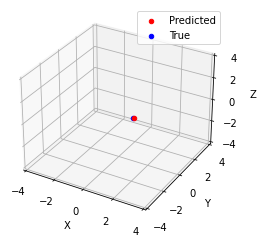

In [28]:
# Create a 3D scatter plot of the predicted and true values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[0][0], coordinates[0][1], coordinates[0][2], c='r', marker='o', label='Predicted')
ax.scatter(test_curr_pos[testIndex][0], test_curr_pos[testIndex][1], test_curr_pos[testIndex][2], c='b', marker='o', label='True')

# Set the limits for each axis to 5
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
ax.set_zlim([-4, 4])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()